# Three Gradient Descent Algorithms

## SGD, Adam, and SCG

In [1]:
import numpy as np
import pandas

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23*4]
data = data.dropna(axis=0)
data.shape

(87, 2)

In [3]:
hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)
np.hstack((X, T))[:10]  # show the first 10 samples of hour, CO

array([[18. ,  2.6],
       [19. ,  2. ],
       [20. ,  2.2],
       [21. ,  2.2],
       [22. ,  1.6],
       [23. ,  1.2],
       [ 0. ,  1.2],
       [ 1. ,  1. ],
       [ 2. ,  0.9],
       [ 3. ,  0.6]])

In [18]:
def cubic_model(W, X):
    # print('model W', W, 'X5', X[:5])
    return np.hstack((X, X**2, X**3)) @ W[1:, :] + W[0, :]

def cubic_model_gradient(W, model_not_used, X, T):
    dEdY = -2 * (T - cubic_model(W, X))
    all_but_bias = np.hstack((X, X**2, X**3))
    dYdW = np.insert(all_but_bias, 0, 1, axis=1)
    result = dEdY.T @ dYdW / X.shape[0]
    return result.T

def mse(W, model, X, T):
    Y = model(W, X)
    return np.mean((T - Y)**2)

## Stochastic Gradient Descent (SGD)

Use the cell magic command `%%writefile` to save this function for use in future lectures.

In [5]:
%%writefile optimizers.py

import numpy as np
import sys
import copy
import time
import math  # for math.ceil

def sgd(w, error_f, error_gradient_f, fargs=[], n_iterations=100, eval_f=lambda x: x,
        learning_rate=0.001, momentum_rate=0.0, save_wtrace=False, verbose=False):

    w = w.copy()
    
    startTime = time.time()
    startTimeLastVerbose = startTime
    
    nW = len(w)

    wtrace = [w.copy()] if save_wtrace else None
    ftrace = [eval_f(error_f(w, *fargs))]
    
    w_change = 0
    for iteration in range(n_iterations):
        fnow = error_f(w, *fargs)  # to calculate layer outputs for gradient calculation
        grad = error_gradient_f(w, *fargs)
        w_change = -learning_rate * grad + momentum_rate * w_change
        w += w_change
        if save_wtrace:
            wtrace.append(w.copy())
        ftrace.append(eval_f(fnow))

        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and (iteration + 1) % max(1, iterations_per_print) == 0:
            seconds = time.time() - startTimeLastVerbose
            print(f'SGD: Iteration {iteration+1:d} ObjectiveF={eval_f(fnow):.5f} Seconds={seconds:.3f}')
            startTimeLastVerbose = time.time()

    return {'w': w,
            'f': error_f(w, *fargs),
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 1,:] if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 1],
            'reason': 'iterations',
            'time': time.time() - startTime}


Overwriting optimizers.py


In [6]:
import optimizers as opt

In [7]:
result = opt.sgd(np.zeros((4, 1)), mse, cubic_model_gradient, fargs=[cubic_model, X, T],
                 n_iterations=20000, learning_rate=1e-8, momentum_rate=0.8, verbose=True)

SGD: Iteration 2000 ObjectiveF=2.58176 Seconds=0.909
SGD: Iteration 4000 ObjectiveF=2.13536 Seconds=1.161
SGD: Iteration 6000 ObjectiveF=1.90689 Seconds=0.600
SGD: Iteration 8000 ObjectiveF=1.78992 Seconds=0.573
SGD: Iteration 10000 ObjectiveF=1.73000 Seconds=0.509
SGD: Iteration 12000 ObjectiveF=1.69928 Seconds=0.444
SGD: Iteration 14000 ObjectiveF=1.68349 Seconds=0.419
SGD: Iteration 16000 ObjectiveF=1.67535 Seconds=0.395
SGD: Iteration 18000 ObjectiveF=1.67111 Seconds=0.419
SGD: Iteration 20000 ObjectiveF=1.66887 Seconds=0.396


In [8]:
result.keys()

dict_keys(['w', 'f', 'n_iterations', 'wtrace', 'ftrace', 'reason', 'time'])

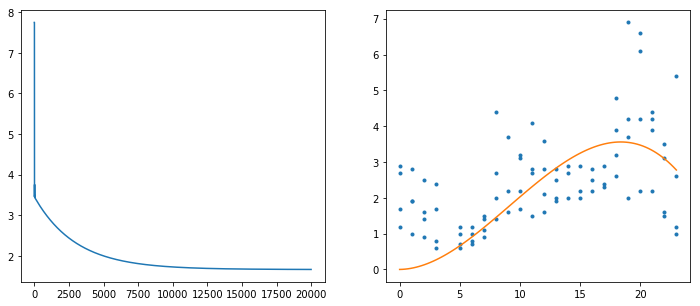

In [9]:
def plot_result(result):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(result['ftrace'])

    plt.subplot(1, 2, 2)
    plt.plot(X, T, '.')
    xs = np.linspace(0, 23, 100).reshape((-1, 1))
    W = result['w']
    plt.plot(xs, cubic_model(W, xs))
    
plot_result(result)

## Adaptive Moment Estimation (Adam)

In [19]:
%%writefile -a optimizers.py

def adam(w, error_f, error_gradient_f, fargs=[], n_iterations=100, eval_f=lambda x: x,
         learning_rate=0.001, save_wtrace=False, verbose=False):

    w = w.copy()
    
    startTime = time.time()
    startTimeLastVerbose = startTime
    
    beta1 = 0.9
    beta2 = 0.999
    alpha = learning_rate
    epsilon = 10e-8
    nW = len(w)
    g = np.zeros((nW, 1))
    g2 = np.zeros((nW, 1))
    beta1t = beta1
    beta2t = beta2

    wtrace = [w.copy()] if save_wtrace else None
    ftrace = [eval_f(error_f(w, *fargs))]
    
    for iteration in range(n_iterations):
        fnow = error_f(w, *fargs)  # to calculate layer outputs for gradient calculation
        grad = error_gradient_f(w, *fargs)
        g = beta1 * g + (1 - beta1) * grad
        g2 = beta2 * g2 + (1 - beta2) * grad * grad

        beta1t *= beta1
        beta2t *= beta2
        alphat = alpha * np.sqrt(1 - beta2t) / (1 - beta1t)
        # print(w.shape, g.shape, g2.shape)
        w -= alphat * g / (np.sqrt(g2) + epsilon)
        if save_wtrace:
            wtrace.append(w.copy())
        ftrace.append(eval_f(fnow))

        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and (iteration + 1) % max(1, iterations_per_print) == 0:
            seconds = time.time() - startTimeLastVerbose
            print(f'Adam: Iteration {iteration+1:d} ObjectiveF={eval_f(fnow):.5f} Seconds={seconds:.3f}')
            startTimeLastVerbose = time.time()

    return {'w': w,
            'f': error_f(w, *fargs),
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 1,:] if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 1],
            'reason': 'iterations',
            'time': time.time() - startTime}


Appending to optimizers.py


In [20]:
import importlib
importlib.reload(opt)

<module 'optimizers' from 'C:\\Users\\Sarah\\Documents\\Sarah\\Grad Comp Sci\\CS 545\\optimizers.py'>

In [21]:
result = opt.adam(np.zeros((4, 1)), mse, cubic_model_gradient, fargs=[cubic_model, X, T],
                  n_iterations=10000, learning_rate=1e-3, verbose=True)

Adam: Iteration 1000 ObjectiveF=1.51017 Seconds=0.561
Adam: Iteration 2000 ObjectiveF=1.25215 Seconds=0.405
Adam: Iteration 3000 ObjectiveF=1.20770 Seconds=0.405
Adam: Iteration 4000 ObjectiveF=1.17874 Seconds=0.410
Adam: Iteration 5000 ObjectiveF=1.15920 Seconds=0.424
Adam: Iteration 6000 ObjectiveF=1.14632 Seconds=0.328
Adam: Iteration 7000 ObjectiveF=1.13795 Seconds=0.316
Adam: Iteration 8000 ObjectiveF=1.13257 Seconds=0.256
Adam: Iteration 9000 ObjectiveF=1.12910 Seconds=0.315
Adam: Iteration 10000 ObjectiveF=1.12687 Seconds=0.296


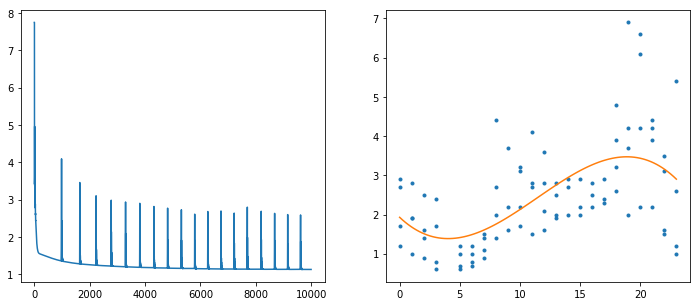

In [22]:
plot_result(result)

## Scaled Conjugate Gradient (SCG)

In [23]:
%%writefile -a optimizers.py

######################################################################
# Scaled Conjugate Gradient algorithm from
#  "A Scaled Conjugate Gradient Algorithm for Fast Supervised Learning"
#  by Martin F. Moller
#  Neural Networks, vol. 6, pp. 525-533, 1993
#
#  Adapted by Chuck Anderson from the Matlab implementation by Nabney
#   as part of the netlab library.
#


def scg(w, error_f, error_gradient_f, fargs=[], n_iterations=100, eval_f=lambda x: x,
        save_wtrace=False, verbose=False):

    float_precision = sys.float_info.epsilon

    w = w.copy()
    sigma0 = 1.0e-6
    fold = error_f(w, *fargs)
    fnow = fold
    gradnew = error_gradient_f(w, *fargs)
    gradold = copy.deepcopy(gradnew)
    d = -gradnew      # Initial search direction.
    success = True    # Force calculation of directional derivs.
    nsuccess = 0      # nsuccess counts number of successes.
    beta = 1.0e-6     # Initial scale parameter. Lambda in Moeller.
    betamin = 1.0e-15 # Lower bound on scale.
    betamax = 1.0e20  # Upper bound on scale.
    nvars = len(w)
    iteration = 1     # count of number of iterations

    wtrace = [w.copy()] if save_wtrace else None
    ftrace = [eval_f(fold)]

    thisIteration = 1
    startTime = time.time()
    startTimeLastVerbose = startTime

    # Main optimization loop.
    while thisIteration <= n_iterations:

        # Calculate first and second directional derivatives.
        if success:
            mu = d.T @ gradnew
            if mu >= 0:
                d = -gradnew
                mu = d.T @ gradnew
            kappa = d.T @ d
            if math.isnan(kappa):
                print('kappa', kappa)

            if kappa < float_precision:
                return {'w': w,
                        'f': fnow,
                        'n_iterations': iteration,
                        'wtrace': np.array(wtrace)[:iteration + 1, :] if save_wtrace else None, 
                        'ftrace': np.array(ftrace)[:iteration + 1],
                        'reason': 'limit on machine precision',
                        'time': time.time() - startTime}
            sigma = sigma0 / math.sqrt(kappa)

            w_smallstep = w + sigma * d
            error_f(w_smallstep, *fargs)  # forward pass through model for intermediate variable values for gradient
            g_smallstep = error_gradient_f(w_smallstep, *fargs)
            theta = d.T @ (g_smallstep - gradnew) / sigma
            if math.isnan(theta):
                print(f'theta {theta} sigma {sigma} d[0] {d[0]} g_smallstep[0] {g_smallstep[0]} gradnew[0] {gradnew[0]}')

        ## Increase effective curvature and evaluate step size alpha.
        delta = theta + beta * kappa
        if math.isnan(delta):
            print(f'delta is NaN theta {theta} beta {beta} kappa {kappa}')
        elif delta <= 0:
            delta = beta * kappa
            beta = beta - theta / kappa

        if delta == 0:
            success = False
            fnow = fold
        else:
            alpha = -mu / delta
            ## Calculate the comparison ratio Delta
            wnew = w + alpha * d
            fnew = error_f(wnew, *fargs)
            Delta = 2 * (fnew - fold) / (alpha * mu)
            if not math.isnan(Delta) and Delta  >= 0:
                success = True
                nsuccess += 1
                w[:] = wnew
                fnow = fnew
            else:
                success = False
                fnow = fold

        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and thisIteration % max(1, iterations_per_print) == 0:
            seconds = time.time() - startTimeLastVerbose
            print(f'SCG: Iteration {iteration:d} ObjectiveF={eval_f(fnow):.5f} Scale={beta:.3e} Seconds={seconds:.3f}')
            startTimeLastVerbose = time.time()
        if save_wtrace:
            wtrace.append(w.copy())
        ftrace.append(eval_f(fnow))

        if success:

            fold = fnew
            gradold[:] = gradnew
            gradnew[:] = error_gradient_f(w, *fargs)

            # If the gradient is zero then we are done.
            gg = gradnew.T @ gradnew
            if gg == 0:
                return {'w': w,
                        'f': fnow,
                        'n_iterations': iteration,
                        'wtrace': np.array(wtrace)[:iteration + 1, :] if save_wtrace else None,
                        'ftrace': np.array(ftrace)[:iteration + 1],
                        'reason': 'zero gradient',
                        'time': time.time() - startTime}

        if math.isnan(Delta) or Delta < 0.25:
            beta = min(4.0 * beta, betamax)
        elif Delta > 0.75:
            beta = max(0.5 * beta, betamin)

        # Update search direction using Polak-Ribiere formula, or re-start
        # in direction of negative gradient after nparams steps.
        if nsuccess == nvars:
            d[:] = -gradnew
            nsuccess = 0
        elif success:
            gamma = (gradold - gradnew).T @ (gradnew / mu)
            d[:] = gamma * d - gradnew

        thisIteration += 1
        iteration += 1

        # If we get here, then we haven't terminated in the given number of iterations.

    return {'w': w,
            'f': fnow,
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 1,:] if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 1],
            'reason': 'did not converge',
            'time': time.time() - startTime}


Appending to optimizers.py


In [24]:
importlib.reload(opt)

<module 'optimizers' from 'C:\\Users\\Sarah\\Documents\\Sarah\\Grad Comp Sci\\CS 545\\optimizers.py'>

In [25]:
result = opt.scg(np.zeros((4, 1)), mse, cubic_model_gradient, fargs=[cubic_model, X, T],
                n_iterations=200, verbose=True)

SCG: Iteration 20 ObjectiveF=1.12562 Scale=1.907e-12 Seconds=0.048
SCG: Iteration 40 ObjectiveF=1.12315 Scale=1.000e-15 Seconds=0.035
SCG: Iteration 60 ObjectiveF=1.12292 Scale=1.000e-15 Seconds=0.046
SCG: Iteration 80 ObjectiveF=1.12290 Scale=1.000e-15 Seconds=0.023
SCG: Iteration 100 ObjectiveF=1.12290 Scale=1.000e-15 Seconds=0.021
SCG: Iteration 120 ObjectiveF=1.12290 Scale=1.000e-15 Seconds=0.020
SCG: Iteration 140 ObjectiveF=1.12290 Scale=1.000e-15 Seconds=0.018
SCG: Iteration 160 ObjectiveF=1.12290 Scale=1.100e-03 Seconds=0.004
SCG: Iteration 180 ObjectiveF=1.12290 Scale=1.126e+00 Seconds=0.020
SCG: Iteration 200 ObjectiveF=1.12290 Scale=1.074e-06 Seconds=0.039


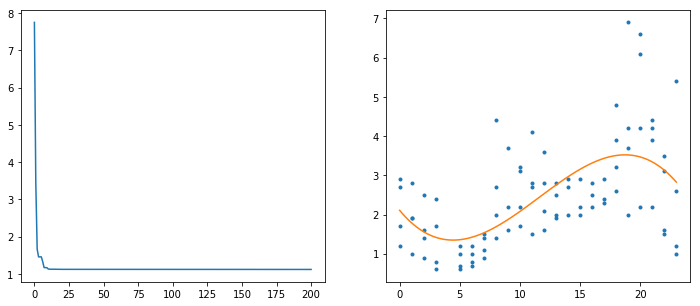

In [26]:
plot_result(result)

Running the three optimizations again, and superimposing their results on the plots.

In [27]:
result_sgd = opt.sgd(np.zeros((4, 1)), 
                     mse, cubic_model_gradient, fargs=[cubic_model, X, T],
                     n_iterations=20000, learning_rate=1e-8, momentum_rate=0.8)

In [28]:
result_adam = opt.adam(np.zeros((4, 1)), 
                       mse, cubic_model_gradient, fargs=[cubic_model, X, T],
                        n_iterations=10000, learning_rate=1e-3)

In [29]:
result_scg = opt.scg(np.zeros((4, 1)),
                     mse, cubic_model_gradient, fargs=[cubic_model, X, T],
                     n_iterations=200)

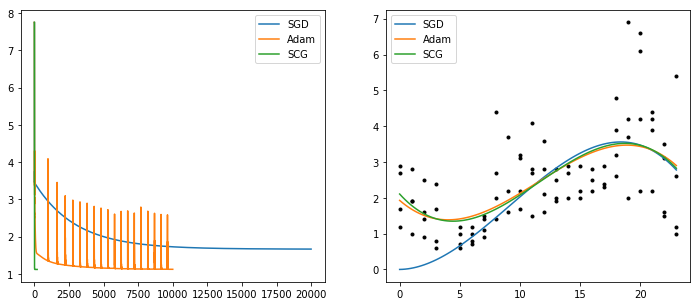

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(result_sgd['ftrace'], label='SGD')
plt.plot(result_adam['ftrace'], label='Adam')
plt.plot(result_scg['ftrace'], label='SCG')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(X, T, 'k.')
xs = np.linspace(0, 23, 100).reshape((-1, 1))
plt.plot(xs, cubic_model(result_sgd['w'], xs), label='SGD')
plt.plot(xs, cubic_model(result_adam['w'], xs), label='Adam')
plt.plot(xs, cubic_model(result_scg['w'], xs), label='SCG')
plt.legend();